# Explaining Causal Entropic Forces

The _Physical Review Letters_ paper Causal Entropic Forces [[Wissner-Gross & Freer, 2013a]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf) presents an agent interacting with an environment whose behavior (over time) is governed by a "causal entropic force".
In physics (and information theory), entropy measures the diversity of states a system can be at any one time.
[[Wissner-Gross & Freer, 2013a]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf) define the causal entropy of an agent-environment system as the entropy over the environmental futures caused by the agent, and a causal entropic force as a Newtonian force acting on an agent to maximize causal entropy.

This tutorial is a (re)implementation of the Causal Entropic Forces algorithm in the simplest experiment presented in [[Wissner-Gross & Freer, 2013a]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf) -- the particle in a box.
After introducing some notation, I will first describe the behavior of an agent that does not maximize causal entropy, before explaining the mathematics and algorithmic implementation of an agent that does.

This tutorial is written in mathematics and Python and is adapted from:

1. Causal Entropic Forces [[Wissner-Gross & Freer, 2013a]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf).
2. Supplementary Material to Causal Entropic Forces [[Wissner-Gross & Freer, 2013b]](https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.110.168702).
3. Comment: Causal entropic forces [[Kappen, 2013]](https://arxiv.org/abs/1312.4185).
4. Causal Entropic Forces: Intelligent Behaviour, Dynamics and Pattern Formation [[Hornischer, 2015]](https://pure.mpg.de/rest/items/item_2300851/component/file_2300850/content).
5. Fractal AI: A fragile theory of intelligence [[Cerezo & Ballester, 2018]](https://arxiv.org/abs/1803.05049).

See `notebooks/README.md` for installation instructions on how to run this notebook.

## Notation

I follow the popular physical notation for mathematics and use lowercase $x$ for scalars, bold lowercase $\mathbf{x}$ for vectors and bold uppercase $\mathbf{X}$ for matrices.

I will refer to an agent whose behavior is guided by a random number generator and not a causal entropic force as a random agent, and an agent whose behavior purposefully maximizes causal entropy as a causal-entropic agent.
I am not aware that these term were used for such descriptive purposes in any of the five references above, but [[Wissner-Gross, 2013]](https://www.youtube.com/watch?v=rZB8TNaG-ik) describes an agent that maximizes a causal entropic force as "Entropica".

An agent is individually situated in a physical system whose state at time $t$ is described by a phase space $\mathbf{x}_t = \{ \mathbf{q}_t, \mathbf{p}_t \}$, where $\mathbf{q}$ and $\mathbf{p}$ are respectively position and momentum vectors that have the same number of elements.
Note that in the particle-in-a-box experiment that there is only one agent in the environment.

## A Random Agent

This section is adapted from page 2 of [[Wissner-Gross & Freer, 2013a]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf) and pages 2 and 3 of [[Wissner-Gross & Freer, 2013b]](https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.110.168702).

A random agent causes the state component $j$ to evolve through time following the Langevin dynamics of
$$
\begin{align*}
    \dot{p}_{j, t}
    &=
    g_j(\mathbf{x}_t, t)
\\
    \dot{q}_{j, t}
    &=
    \frac{p_{j, t}}{m_{j}}
\end{align*}
$$
where $m_j$ is the effective mass of component $j$.

$g_j(\mathbf{x}_t, t)$ is the energetic force of component $j$ and evolves in discrete timesteps of duration $\epsilon$ following
$$
\begin{align*}
    g_j(\mathbf{x}_t, t)
    =
    - \frac{1}{\epsilon} \, p_j \left( \left\lfloor \frac{t}{\epsilon} \right\rfloor \epsilon \right)
    + f_j \left( \left\lfloor \frac{t}{\epsilon} \right\rfloor \epsilon \right)
    + h_j \left( \mathbf{x}_t \right)
\end{align*}
$$
where $h_j$ are deterministic state-dependent internal system forces and $f_j \sim \mathcal{N} \left(\mu = 0, \sigma = \frac{1}{\epsilon} \sqrt{m_j \, k_B \, T_r} \right)$ is a random variable sampled iid at every timestep at every $j$, with $T_r$ the temperature of the heat reservoir of the system.

The use of the random variable $f_j$ in this agent is what gives the random agent its name.

The following code visualizes how the energetic force drives the evolution of a random agent in the particle-in-a-box physical system.

In [1]:
import numpy as np
import scipy

from matplotlib import pyplot as plt
from matplotlib import patches as patches
from matplotlib import cm

import copy

In [2]:
np.random.seed(0)

In [3]:
EPSILON = .025
M       = 1e-21
T_R     = 4e5
K_B     = scipy.constants.Boltzmann
TAU     = 10.

L     = 400
Q_MIN = np.array([0., 0.  ])
Q_MAX = np.array([L , L/5.])

p_max = M * np.abs(Q_MAX - Q_MIN) / EPSILON

loc   = 0.
scale = np.sqrt(M * K_B * T_R) / EPSILON
# scale = np.sqrt(K_B * T_R)

timesteps = int(TAU / EPSILON)

In [275]:
q = np.array([L/10., L/10.])
p = np.array([0.   , 0.   ])

path = copy.deepcopy(q[None, :])

for _ in range(timesteps-1):
    f = np.random.normal(loc=loc, scale=scale, size=(2,))
    g = - p / EPSILON + f

    p_dot = g
    p    += p_dot * EPSILON
    # bound the momentum by the maximum momentum
    p     = np.sign(p) * np.minimum(p_max, np.abs(p))
    
    q_dot = p / M
    q    += q_dot * EPSILON
    # perfectly elastic collisions with walls
    q  = np.maximum(q, 2 * Q_MIN - q)
    p *= np.sign(q - Q_MIN)
    q  = np.minimum(q, 2 * Q_MAX - q)
    p *= np.sign(Q_MAX - q)

    path = np.append(path, q[None, :], axis=0)

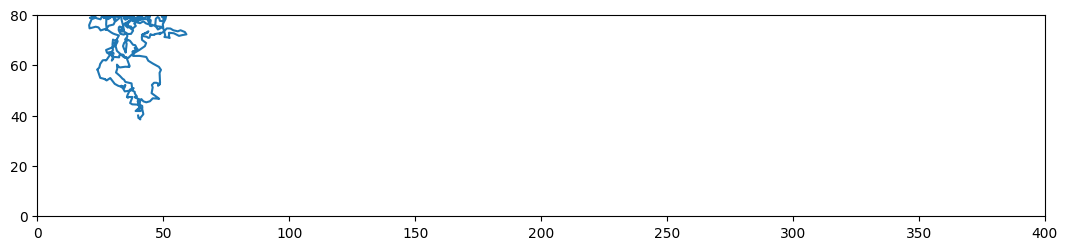

In [276]:
fig, ax = plt.subplots(figsize=(13, 13))
# ax.add_patch(patches.Rectangle(Q_MIN, L, L/5., edgecolor='k', fill=False)) # from https://stackoverflow.com/a/37437395
ax.plot(*path.T)
ax.set_xlim(Q_MIN[0], Q_MAX[0])
ax.set_ylim(Q_MIN[1], Q_MAX[1])
ax.set(aspect='equal')
plt.show()

## A Causal Entropic Agent

A causal entropic agent causes the state component $j$ to evolve through time following the Langevin dynamics of
$$
\begin{align*}
    \dot{p}_{j, t}
    &=
    \mathbb{E}_{f_j} [g_j(\mathbf{x}_t, t)]
    +
    f^{(c)}(\mathbf{x}_t, \tau)
\\
    \dot{q}_{j, t}
    &=
    \frac{p_{j, t}}{m_{j}}
\end{align*}
$$
where $m_j$ is the effective mass of component $j$ and $f^{(c)}(\mathbf{x}_t, \tau)$ is the causal entropic force.

Before I define the causal entropic force, note that the change in momentum simplifies to
$$
\begin{align*}
    \dot{p}_{j, t}
    &=
    \mathbb{E}_{f_j} [g_j(\mathbf{x}_t, t)]
    + f^{(c)}_{j}(\mathbf{x}_t, \tau)
\\
    &=
    \mathbb{E}_{f_j} \left[
        - \frac{1}{\epsilon} \, p_j \left( \left\lfloor \frac{t}{\epsilon} \right\rfloor \epsilon \right)
        + f_j \left( \left\lfloor \frac{t}{\epsilon} \right\rfloor \epsilon \right)
        + h_j \left( \mathbf{x}_t \right)
    \right]
    + f^{(c)}_{j}(\mathbf{x}_t, \tau)
\\
    &=
    - \frac{1}{\epsilon} \, p_j \left( \left\lfloor \frac{t}{\epsilon} \right\rfloor \epsilon \right)
    + h_j \left( \mathbf{x}_t \right)
    + f^{(c)}_{j}(\mathbf{x}_t, \tau)
\end{align*}
$$

### A Causal Entropic Force

The causal entropic force is exerted on state $\mathbf{x}_t$ by a time-horizon of $\tau$ and temperature $T_c$ and defined by
$$
\begin{align*}
    \mathbf{f}^{(c)}(\mathbf{x}_t, \tau) = T_c \, \left. \nabla_{\mathbf{x}} \, s(\mathbf{x}, \tau) \right|_{\mathbf{x}_t}
\end{align*}
$$

Here, $s(\mathbf{x}_t, \tau)$ is the causal entropy from $\mathbf{x}_t$ with a time-horizon of $\tau$:
$$
\begin{align*}
    s(\mathbf{x}_t, \tau) =
    - k_B \,
    \mathbb{E}_{\mathbf{x}_{t+\tau} \sim p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)}
    \left[
        \ln p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
    \right]
\end{align*}
$$
and $k_B$ is the Boltzmann constant.

The probability distribution over states $\tau$ timesteps from $t$ is
$$
\begin{align*}
    p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t) = 
    \int p(\mathbf{x}_{t+\tau}, \mathbf{x}_{t:t+\tau} \mid \mathbf{x}_t) \,\mathrm{d}\mathbf{x}_{t:t+\tau}
\end{align*}
$$
where $\mathbf{x}_{t:t+\tau}$ denotes all possible paths from $\mathbf{x}_t$ to $\mathbf{x}_{t+\tau}$.

As the system dynamics evolve in discrete time, the above probability distribution becomes the following Markov chain
$$
\begin{align*}
    p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t) = 
    \sum_{\mathbf{x}_{t+\epsilon} , \mathbf{x}_{t+2\epsilon} , \cdots \mathbf{x}_{t + \tau - \epsilon}}
    p(\mathbf{x}_{t+\epsilon} \mid \mathbf{x}_t)
    \prod_{n=1}^{\tau/\epsilon-1}
        p(\mathbf{x}_{t + (n+1)\epsilon} \mid \mathbf{x}_{t + n\epsilon})
\end{align*}
$$

### Calculating The Causal Entropic Force

This section is adapted from pages 2 and 3 of [[Wissner-Gross & Freer, 2013a]](http://math.mit.edu/~freer/papers/PhysRevLett_110-168702.pdf) and Section 3.1 of [[Hornischer, 2015]](https://pure.mpg.de/rest/items/item_2300851/component/file_2300850/content) and describes how to calculate the causal entropic force component $f^{(c)}_j(\mathbf{x}_t, \tau)$.

The units of (causal) entropy is $J/K$ due to the Boltzmann constant, and multiplying the causal entropy by a temperature produces an energetic quantity.
As the derivative of energy wrt position determines a force, the causal entropic force on component $j$ of the physical system is
$$
\begin{align*}
    f^{(c)}_j(\mathbf{x}_t, \tau)
    &= T_c \, \left. \frac{\partial}{\partial q_j} \, s(\{ \mathbf{q}, \mathbf{p}_t \}, \tau) \right|_{\mathbf{q}_t}
\\
    &= - T_c \, k_B \, \left. \frac{\partial}{\partial q_j} \,
    \mathbb{E}_{\mathbf{x}_{t+\tau} \sim p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})}
    \left[
        \ln p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})
    \right]\right|_{\mathbf{q}_t}
\\
    &= - T_c \, k_B \, \left. \frac{\partial}{\partial q_j}
    \int
        p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \}) \ln p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})
        \,\mathrm{d} \mathbf{x}_{t+\tau}
    \right|_{\mathbf{q}_t}
\\
    &= - T_c \, k_B \, \left.
    \int
        \frac{\partial}{\partial q_j} \,
        p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \}) \ln p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})
        \,\mathrm{d} \mathbf{x}_{t+\tau}
    \right|_{\mathbf{q}_t}
\\
    &= - T_c \, k_B \, \left.
    \int
        \frac{\partial \, p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})}{\partial q_j}
        \ln p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
        + p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \}) \frac{\partial \ln p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})}{\partial q_j}
        \,\mathrm{d} \mathbf{x}_{t+\tau}
    \right|_{\mathbf{q}_t}
\\
    &= - T_c \, k_B \, \left.
    \int
        \frac{\partial \, p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})}{\partial q_j}
        \ln p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
        + \frac{\partial}{\partial q_j} p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})
        \,\mathrm{d} \mathbf{x}_{t+\tau}
    \right|_{\mathbf{q}_t}
\\
    &= - T_c \, k_B
    \int
        \left.
            \frac{\partial}{\partial q_j} p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})
        \right|_{\mathbf{q}_t}
        \ln p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
    \,\mathrm{d} \mathbf{x}_{t+\tau}
    + \left. \int
        \frac{\partial}{\partial q_j} p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})
    \,\mathrm{d} \mathbf{x}_{t+\tau}
    \right|_{\mathbf{q}_t}
\\
    &= - T_c \, k_B
    \int
        \left.
            \frac{\partial}{\partial q_j} p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})
        \right|_{\mathbf{q}_t}
        \ln p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
    \,\mathrm{d} \mathbf{x}_{t+\tau}
    + \frac{\partial}{\partial q_j} 1
\\
    &= - T_c \, k_B
    \int
        \left.
            \frac{\partial}{\partial q_j} p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})
        \right|_{\mathbf{q}_t}
        \ln p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
    \,\mathrm{d} \mathbf{x}_{t+\tau}
\end{align*}
$$

Now, substituting the Markov chain probability definition,
$$
\begin{align*}
    \left.
        \frac{\partial}{\partial q_j} p(\mathbf{x}_{t+\tau} \mid \{ \mathbf{q}, \mathbf{p}_t \})
    \right|_{\mathbf{q}_j}
&=
    \left.
        \frac{\partial}{\partial q_j} \,
        \sum_{\mathbf{x}_{t+\epsilon} , \mathbf{x}_{t+2\epsilon} , \cdots \mathbf{x}_{t + \tau - \epsilon}}
        p(\mathbf{x}_{t+\epsilon} \mid \{ \mathbf{q}, \mathbf{p}_t \})
        \prod_{n=1}^{\tau/\epsilon-1}
            p(\mathbf{x}_{t + (n+1)\epsilon} \mid p(\mathbf{x}_{t + n\epsilon})
    \right|_{\mathbf{q}_j}
\\
&=
    \sum_{\mathbf{x}_{t+\epsilon} , \mathbf{x}_{t+2\epsilon} , \cdots \mathbf{x}_{t + \tau - \epsilon}}
    \left.
        \frac{\partial}{\partial q_j} \,
        p(\mathbf{x}_{t+\epsilon} \mid \{ \mathbf{q}, \mathbf{p}_t \})
    \right|_{\mathbf{q}_j}
    \prod_{n=1}^{\tau/\epsilon-1}
        p(\mathbf{x}_{t + (n+1)\epsilon} \mid p(\mathbf{x}_{t + n\epsilon})
\end{align*}
$$

The quantity in $p$ that the above derivative depends on is $q_{j, t+\epsilon}$, whose value is determined by one step of Langevin dynamics from $q_{j, t}$
$$
\begin{align*}
    q_{j, t+\epsilon}
    &= q_{j, t} + \dot{q}_{j, t} \, \epsilon
\\
    &= q_{j, t} + \frac{p_{j, t}}{m_{j}} \epsilon
\\
    &= q_{j, t} + \frac{p_{j, t} + \dot{p}_{j, t} \, \epsilon}{m_{j}} \epsilon
\\
    &= q_{j, t} + \frac{p_{j, t}}{m_{j}} \epsilon + \frac{
    - \frac{1}{\epsilon} \, p_{j, t} + f_{j, t} + h_j(\mathbf{x}_t)}{m_{j}} \epsilon^2
\\
    % &= q_{j, t} + \frac{p_{j, t}}{m_{j}} \epsilon + \frac{f_{j, t} + h_j(\mathbf{x}_t)}{m_{j}} \epsilon^2
    % &= q_{j, t} + \left( f_{j, t} + h_j(\mathbf{x}_t) \right) \frac{\epsilon^2}{m_{j}}
    &= q_{j, t} + \frac{f_{j, t} + h_j(\mathbf{x}_t)}{m_{j}} \epsilon^2
\\
    &= q_{j, t} + f_{j, t} \frac{\epsilon^2}{m_{j}} + h_j(\mathbf{x}_t) \frac{\epsilon^2}{m_{j}}
\end{align*}
$$

**Note 1**: My expression for $q_{j, t+\epsilon}$ differs from that 

As $f_{j, t}$ is a normal random variable, $q_{j, t+\epsilon} \mid q_{j, t}$ is also a normal random variable determined by
$$
\begin{align*}
    p(q_{j, t+\epsilon} \mid q_{j, t})
&=
    \mathcal{N} \left( \mu= q_{j, t} + h_j(\mathbf{x}_t) \frac{\epsilon^2}{m_{j}}, \sigma^2= k_B \, T_r \, \frac{\epsilon^2}{m_j} \right)
\end{align*}
$$
and $p(\mathbf{x}_{t+\epsilon} \mid \mathbf{x}_t)$ is completely determined by $p(\mathbf{q}_{t+\epsilon} \mid \mathbf{q}_t)$, which is calculated by multiplying together all $p(q_{j, t+\epsilon} \mid q_{j, t})$ over $j$.

Thus, focusing only on one $p(q_{j, t+\epsilon} \mid q_{j, t})$, the gradient sought to calculate the entropic force may be rewritten as follows following the property of a normal distribution.
$$
\begin{align*}
    \left.
        \frac{\partial}{\partial q_j} \, p(q_{j, t+\epsilon} \mid q_j)
    \right|_{q_t}
&=
    -
    \left.
        \frac{\partial}{\partial q_j} \, p( q_j \mid q_{j, t} )
    \right|_{q_{t+\epsilon}}
\end{align*}
$$

Now, as for an arbitrary normal distribution
$$
\begin{align*}
    \frac{\partial}{\partial x} p(x)
    &=
    \frac{\partial}{\partial x} \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(- \frac{(x - \mu)^2}{2 \sigma^2} \right)
\\
    &=
    - \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(- \frac{(x - \mu)^2}{2 \sigma^2} \right)
    \frac{\partial}{\partial x} \frac{(x - \mu)^2}{2 \sigma^2}
\\
    &=
    - \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(- \frac{(x - \mu)^2}{2 \sigma^2} \right)
    \frac{x - \mu}{\sigma^2}
\\
    &=
    - p(x) \frac{x - \mu}{\sigma^2}
\end{align*}
$$

so, after substitution the definitions of $\mu$ and $\sigma$,
$$
\begin{align*}
    -
    \left.
        \frac{\partial}{\partial q_j} \, p( q_j \mid q_{j, t} )
    \right|_{q_{t+\epsilon}}
&=
    - p( q_j \mid q_{j, t} ) \frac{f_{j,t}}{k_B \, T_r}
\end{align*}
$$
<!-- $$
\begin{align*}
    -
    \left.
        \frac{\partial}{\partial q_j} \, p(\mathbf{x}_{t+\epsilon} \mid \{ \mathbf{q}, \mathbf{p}_t \})
    \right|_{\mathbf{q}_{t+\epsilon}}
&=
    - p(\mathbf{x}_{t+\epsilon} \mid \mathbf{x}_t) \frac{f_{j,t}}{k_B \, T_r}
\end{align*}
$$ -->

and the causal entropic force on component $j$ is calculated as
$$
\begin{align*}
    f^{(c)}_j(\mathbf{x}_t, \tau)
    &= - \frac{T_c}{T_r}
    \int
        f_{j,t} \,
        p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
        \ln p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
    \,\mathrm{d} \mathbf{x}_{t+\tau}
\end{align*}
$$

**Note 2**: As a result of Note 1, my expression for $f^{(c)}_j(\mathbf{x}_t, \tau)$ is off by a factor of 2 compared to the original expresision.

### An Approximate Calculation for The Causal Entropic Force

The expression derived in the previous section for the causal entropic force requires computing an integral over states.
When the states are high-dimensional continuous quantities, an integral over them is intractable.
This section presents a Monte-Carlo approach to approximate the integral and is based on page 10 of [[Wissner-Gross & Freer, 2013b]](https://journals.aps.org/prl/supplemental/10.1103/PhysRevLett.110.168702) and Section 3.2 of [[Hornischer, 2015]](https://pure.mpg.de/rest/items/item_2300851/component/file_2300850/content).

Consider $M$ Monte-Carlo samples of $\mathbf{x}_{t+\tau}^{(i)}$s for $i$ from $1$ to $M$.
For convenience, denote the following conditional likelihood as 
$$
\begin{align*}
    p(\mathbf{x}_{t+\tau}^{(i)} \mid \mathbf{x}_t)
    =
    \frac{1}{M \, \Omega_i}
\end{align*}
$$

The $M$-sample Monte-Carlo estimate of the causal entropic force is
$$
\begin{align*}
    f^{(c)}_j(\mathbf{x}_t, \tau)
    &= - \frac{T_c}{T_r}
    \int
        f_{j,t} \,
        p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
        \ln p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
    \,\mathrm{d} \mathbf{x}_{t+\tau}
\\
    &= - \frac{T_c}{T_r} \,
    \mathbb{E}_{\mathbf{x}_{t+\tau} \sim p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)} [
        f_{j,t} \,
        \ln p(\mathbf{x}_{t+\tau} \mid \mathbf{x}_t)
    ]
\\
    &\approx - \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln p(\mathbf{x}_{t+\tau}^{(i)} \mid \mathbf{x}_t)
\\
    &= - \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln \frac{1}{M \, \Omega_i}
\\
    &= \frac{T_c}{T_r}
    \frac{1}{M}
    \left(
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln M
    + \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln \Omega_i
    \right)
\\
    &\approx \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln \Omega_i
\end{align*}
$$

The first term in the penultimate line disappears because
$$
\begin{align*}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)}
&\approx
    0
\end{align*}
$$

The above approximation also implies that
$$
\begin{align*}
    \left(
        \frac{1}{M}
        \sum_{i=1}^M
            f_{j,t}^{(i)}
    \right)
    \ln \sum_{i=1}^M
        \Omega_i
\approx
    0
\end{align*}
$$

so
$$
\begin{align*}
    \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln \Omega_i
&\approx
    \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)} \,
        \ln \Omega_i
    -
    \frac{T_c}{T_r}
    \left(
        \frac{1}{M}
        \sum_{i=1}^M
            f_{j,t}^{(i)}
    \right)
    \ln \sum_{i=1}^M
        \Omega_i
\\
&=
    \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)}
        \left(
            \ln \Omega_i
            - \ln \sum_{i=1}^M
                \Omega_i
        \right)
\\
&=
    \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)}
        \ln \frac{\Omega_i}{\sum_{i=1}^M \Omega_i}
\end{align*}
$$

and therefore
$$
\begin{align*}
    f^{(c)}_j(\mathbf{x}_t, \tau)
&\approx
    \frac{T_c}{T_r}
    \frac{1}{M}
    \sum_{i=1}^M
        f_{j,t}^{(i)}
        \ln \frac{\Omega_i}{\sum_{i=1}^M \Omega_i}
\end{align*}
$$

**Note 3**: I seem to be missing an expectation over the entire term over $f$, and I am not sure why that expectation should be there.

In [291]:
# create array of (num_samples, timesteps, q_dim)

num_samples = 1000

q = np.array([L/10., L/10.])
p = np.array([0.   , 0.   ])

qs = np.tile(q[None, :], (num_samples, 1))
ps = np.tile(p[None, :], (num_samples, 1))

paths  = copy.deepcopy(qs[None, :])
all_fs = np.zeros((timesteps, num_samples, 2))

# create MC rollouts producing array (timesteps, num_samples, q_dim)
for i in range(timesteps-1):
    fs = np.random.normal(loc=loc, scale=scale, size=(num_samples, 2))
    gs = - ps / EPSILON + fs

    all_fs[i] = fs

    p_dots = gs
    ps    += p_dots * EPSILON
    # bound the momentum by the maximum momentum
    ps     = np.sign(ps) * np.minimum(p_max, np.abs(ps))
    
    q_dots = ps / M
    qs    += q_dots * EPSILON
    # perfectly elastic collisions with walls
    qs  = np.maximum(qs, 2 * Q_MIN - qs)
    ps *= np.sign(qs - Q_MIN)
    qs  = np.minimum(qs, 2 * Q_MAX - qs)
    ps *= np.sign(Q_MAX - qs)

    paths = np.append(paths, qs[None, :], axis=0)

In [292]:
# # Plot the random walks
# fig, ax = plt.subplots(figsize=(13, 13))
# ax.plot(*paths.T, alpha=0.1)
# ax.set_xlim(Q_MIN[0], Q_MAX[0])
# ax.set_ylim(Q_MIN[1], Q_MAX[1])
# ax.set(aspect='equal')
# plt.show()

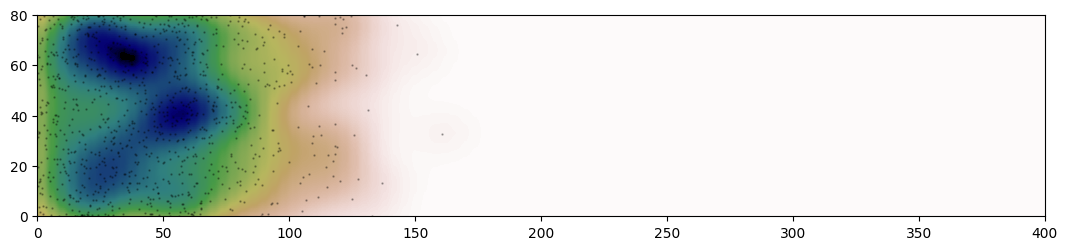

In [293]:
# plot kde of the endpoints and scatter of the endpoints
# Adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

kernel = scipy.stats.gaussian_kde(paths[-1].T)

# estimate pdf
X, Y      = np.mgrid[Q_MIN[0]:Q_MAX[0]:100j, Q_MIN[1]:Q_MAX[1]:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z         = np.reshape(kernel(positions), X.shape)

# plot
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[Q_MIN[0], Q_MAX[0], Q_MIN[1], Q_MAX[1]])
ax.scatter(*paths[-1].T, color='k', s=.5, alpha=.3)
ax.set(aspect='equal')
plt.show()

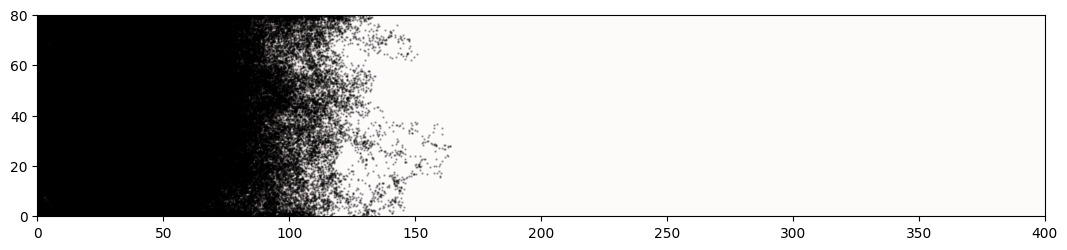

In [297]:
# # plot kde of the endpoints and scatter of the endpoints
# # Adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

# all_points = paths.reshape(-1, 2)

# # estimate pdf
# kernel    = scipy.stats.gaussian_kde(all_points.T)
# X, Y      = np.mgrid[Q_MIN[0]:Q_MAX[0]:100j, Q_MIN[1]:Q_MAX[1]:100j]
# positions = np.vstack([X.ravel(), Y.ravel()])
# Z         = np.reshape(kernel(positions), X.shape)

# # plot
# fig, ax = plt.subplots(figsize=(13, 13))
# ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[Q_MIN[0], Q_MAX[0], Q_MIN[1], Q_MAX[1]])
# # ax.scatter(*all_points.T, color='k', s=.5, alpha=.3)
# ax.set(aspect='equal')
# plt.show()

In [312]:
def calculate_entropic_force(cur_macrostate_q, cur_macrostate_p, tau=10., num_samples=10_000):
    """
    return (num_samples, timesteps, q_dim) and initial_forces
    """
    # q = np.array([L/10., L/10.])
    # p = np.array([0.   , 0.   ])
    
    qs = np.tile(cur_macrostate_q[None, :], (num_samples, 1))
    ps = np.tile(cur_macrostate_p[None, :], (num_samples, 1))
    
    paths  = copy.deepcopy(qs[None, :])
    all_fs = np.zeros((timesteps, num_samples, 2))
    
    # create MC rollouts producing array (timesteps, num_samples, q_dim)
    for i in range(timesteps-1):
        fs = np.random.normal(loc=loc, scale=scale, size=(num_samples, 2))
        gs = - ps / EPSILON + fs
    
        all_fs[i] = fs
    
        p_dots = gs
        ps    += p_dots * EPSILON
        # bound the momentum by the maximum momentum
        ps     = np.sign(ps) * np.minimum(p_max, np.abs(ps))
        
        q_dots = ps / M
        qs    += q_dots * EPSILON
        # perfectly elastic collisions with walls
        qs  = np.maximum(qs, 2 * Q_MIN - qs)
        ps *= np.sign(qs - Q_MIN)
        qs  = np.minimum(qs, 2 * Q_MAX - qs)
        ps *= np.sign(Q_MAX - qs)
    
        paths = np.append(paths, qs[None, :], axis=0)

    endpoints  = paths[-1]
    all_points = paths.reshape(-1, 2)

    # calculate log_volume_fractions
    kernel        = scipy.stats.gaussian_kde(all_points.T)
    # pdfs          = 1. / kernel.pdf(paths[-1].T)
    pdfs          = 1. / kernel.pdf(paths[1].T)
    vol_fracs     = pdfs / pdfs.sum()
    log_vol_fracs = np.log(vol_fracs)
    # assert vol_fracs.sum() == 1., "vol_fracs.sum() != 1."

    # calculate entropic force
    return np.mean(all_fs[0] * log_vol_fracs[:, None], axis=0)

In [313]:
T_C = 5 * T_R

q = np.array([L/10., L/10.])
p = np.array([0.   , 0.   ])

path = copy.deepcopy(q[None, :])

for _ in range(200):
    f_c = T_C / T_R * calculate_entropic_force(q, p, num_samples=100)
    print(q)
    g   = - p / EPSILON + f_c

    p_dot = g
    p    += p_dot * EPSILON
    # bound the momentum by the maximum momentum
    p     = np.sign(p) * np.minimum(p_max, np.abs(p))
    
    q_dot = p / M
    q    += q_dot * EPSILON
    # perfectly elastic collisions with walls
    q  = np.maximum(q, 2 * Q_MIN - q)
    p *= np.sign(q - Q_MIN)
    q  = np.minimum(q, 2 * Q_MAX - q)
    p *= np.sign(Q_MAX - q)

    path = np.append(path, q[None, :], axis=0)

[40. 40.]
[39.76250109 40.05158504]
[44.49116125 49.5538281 ]
[40.53710973 46.9773032 ]
[39.37683635 48.52047238]
[39.67211542 46.58977254]
[35.60629868 41.53257854]
[34.19638555 42.80810509]
[34.6874972  41.58768883]
[38.42719546 41.08816713]
[39.94306058 43.39464795]
[37.3852025  36.86784877]
[32.16054051 37.41690763]
[24.64839387 43.96588069]
[19.39916276 44.87047728]
[15.63408415 46.07018841]
[19.89307944 49.05792955]
[24.00805933 48.48106634]
[23.2676855  49.80459137]
[24.46078603 63.74902995]
[25.52602328 67.5878544 ]
[32.95610726 61.73595753]
[32.2135123  58.11967993]
[34.01248102 56.30846606]
[40.47696764 57.2428506 ]
[39.92438004 53.94465881]
[38.77684029 49.73380241]
[41.54575527 44.52008199]
[47.98936031 38.54265952]
[51.77809793 36.40888061]
[48.68420942 29.25633685]
[54.58451648 27.3996967 ]
[56.64000987 34.43826153]
[53.11568893 40.78615399]
[52.20846883 34.78356746]
[52.48380145 32.86330118]
[53.80980743 31.99443889]
[48.03835221 28.11593503]
[48.4846311  38.80002422]
[4

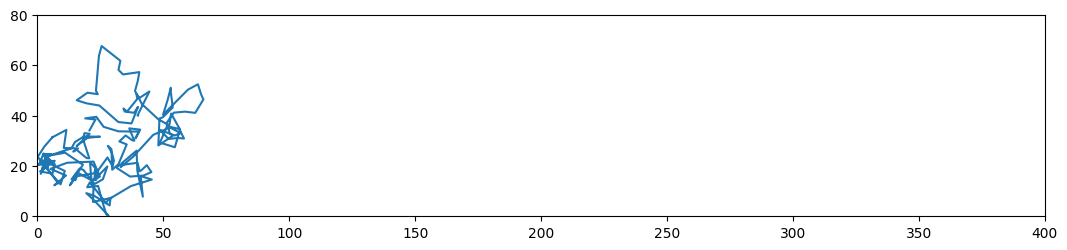

In [314]:
fig, ax = plt.subplots(figsize=(13, 13))
# ax.add_patch(patches.Rectangle(Q_MIN, L, L/5., edgecolor='k', fill=False)) # from https://stackoverflow.com/a/37437395
ax.plot(*path.T)
ax.set_xlim(Q_MIN[0], Q_MAX[0])
ax.set_ylim(Q_MIN[1], Q_MAX[1])
ax.set(aspect='equal')
plt.show()

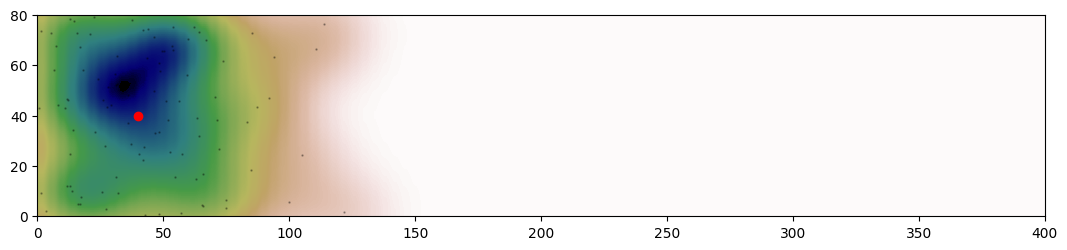

In [299]:
# create array of (timesteps, num_samples, q_dim)

num_samples = 100
qs = np.tile(q[None, :], (num_samples, 1))
ps = np.tile(p[None, :], (num_samples, 1))

paths  = copy.deepcopy(qs[None, :])
all_fs = np.zeros((timesteps, num_samples, 2))

# create MC rollouts producing array (timesteps, num_samples, q_dim)
for i in range(timesteps-1):
    fs = np.random.normal(loc=loc, scale=scale, size=(num_samples, 2))
    gs = - ps / EPSILON + fs

    all_fs[i] = fs

    p_dots = gs
    ps    += p_dots * EPSILON
    # bound the momentum by the maximum momentum
    # ps     = np.sign(ps) * np.minimum(p_max, np.abs(ps))
    
    q_dots = ps / M
    qs    += q_dots * EPSILON
    # perfectly elastic collisions with walls
    qs  = np.maximum(qs, 2 * Q_MIN - qs)
    ps *= np.sign(qs - Q_MIN)
    qs  = np.minimum(qs, 2 * Q_MAX - qs)
    ps *= np.sign(Q_MAX - qs)

    paths = np.append(paths, qs[None, :], axis=0)


# plot kde of the endpoints and scatter of the endpoints
# Adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

kernel = scipy.stats.gaussian_kde(paths[-1].T)

# estimate pdf
X, Y      = np.mgrid[Q_MIN[0]:Q_MAX[0]:100j, Q_MIN[1]:Q_MAX[1]:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z         = np.reshape(kernel(positions), X.shape)

# plot
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[Q_MIN[0], Q_MAX[0], Q_MIN[1], Q_MAX[1]])
ax.scatter(*paths[-1].T, color='k', s=.5, alpha=.3)
ax.scatter(*q, color='r')
ax.set(aspect='equal')
plt.show()

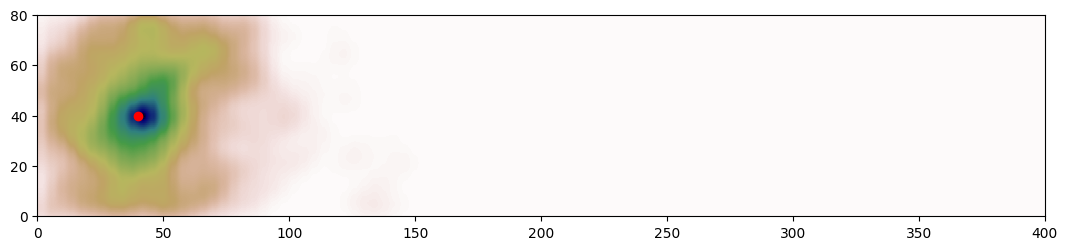

In [301]:
# create array of (timesteps, num_samples, q_dim)

num_samples = 100
qs = np.tile(q[None, :], (num_samples, 1))
ps = np.tile(p[None, :], (num_samples, 1))

paths  = copy.deepcopy(qs[None, :])
all_fs = np.zeros((timesteps, num_samples, 2))

# create MC rollouts producing array (timesteps, num_samples, q_dim)
for i in range(timesteps-1):
    fs = np.random.normal(loc=loc, scale=scale, size=(num_samples, 2))
    gs = - ps / EPSILON + fs

    all_fs[i] = fs

    p_dots = gs
    ps    += p_dots * EPSILON
    # bound the momentum by the maximum momentum
    # ps     = np.sign(ps) * np.minimum(p_max, np.abs(ps))
    
    q_dots = ps / M
    qs    += q_dots * EPSILON
    # perfectly elastic collisions with walls
    qs  = np.maximum(qs, 2 * Q_MIN - qs)
    ps *= np.sign(qs - Q_MIN)
    qs  = np.minimum(qs, 2 * Q_MAX - qs)
    ps *= np.sign(Q_MAX - qs)

    paths = np.append(paths, qs[None, :], axis=0)


# plot kde of the endpoints and scatter of the endpoints
# Adapted from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html

all_points = paths.reshape(-1, 2)

# estimate pdf
kernel    = scipy.stats.gaussian_kde(all_points.T)
X, Y      = np.mgrid[Q_MIN[0]:Q_MAX[0]:100j, Q_MIN[1]:Q_MAX[1]:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z         = np.reshape(kernel(positions), X.shape)

# plot
fig, ax = plt.subplots(figsize=(13, 13))
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[Q_MIN[0], Q_MAX[0], Q_MIN[1], Q_MAX[1]])
# ax.scatter(*all_points.T, color='k', s=.5, alpha=.3)
ax.scatter(*q, color='r')
ax.set(aspect='equal')
plt.show()